In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import textwrap as tw
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.resnet import preprocess_input
from keras_preprocessing.image import ImageDataGenerator


In [3]:
# print all columns
pd.set_option('display.max_columns', None)

# inhibit graphics card runs out of memory
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# default parameter
sns.set_theme(style="ticks")

In [4]:
def load_data(path: str):
    dir = Path(path)
    # list of all filepathes
    filepaths = list(dir.glob(r'**/*.jpg'))
    # list of labels extracted from last foldername of filepath
    labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))
    # series of string filepathes
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    # series of string labels
    labels = pd.Series(labels, name='Labels').astype(str)
    # merge series to dataframe df
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    # Resampling complete rows and reset the index
    return df.sample(frac=1).reset_index(drop=True)


dir = '/Volumes/Extreme SSD/MakeDataset/Skin cancer ISIC The International Skin Imaging Collaboration'
train = '/Volumes/Extreme SSD/MakeDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test = '/Volumes/Extreme SSD/MakeDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

df = load_data(train)

In [5]:
df.head(3)

,FilePaths,Labels
0,/Volumes/Extreme SSD/MakeDataset/Skin cancer I...,melanoma
1,/Volumes/Extreme SSD/MakeDataset/Skin cancer I...,nevus
2,/Volumes/Extreme SSD/MakeDataset/Skin cancer I...,nevus


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239 entries, 0 to 2238
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FilePaths  2239 non-null   object
 1   Labels     2239 non-null   object
dtypes: object(2)
memory usage: 35.1+ KB


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'seborrheic keratosis'),
 Text(1, 0, 'dermatofibroma'),
 Text(2, 0, 'actinic keratosis'),
 Text(3, 0, 'vascular lesion'),
 Text(4, 0, 'squamous cell carcinoma'),
 Text(5, 0, 'nevus'),
 Text(6, 0, 'basal cell carcinoma'),
 Text(7, 0, 'melanoma'),
 Text(8, 0, 'pigmented benign keratosis')]

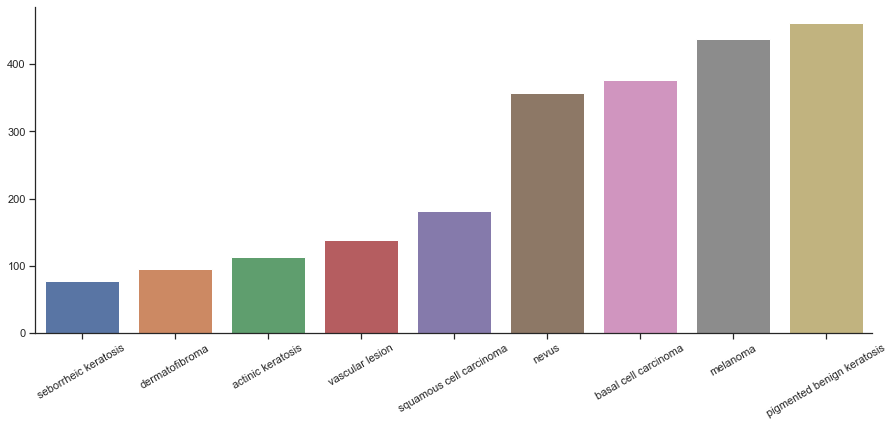

In [7]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(labels_count.index,labels_count.values)
sns.despine()
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

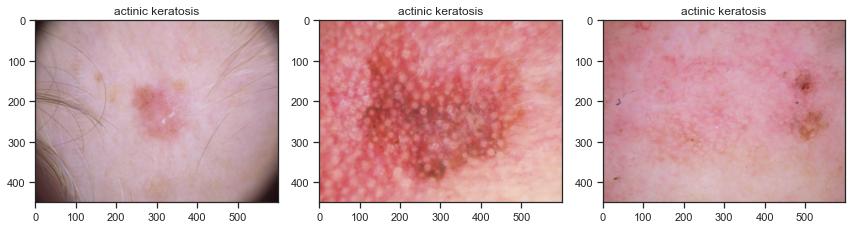

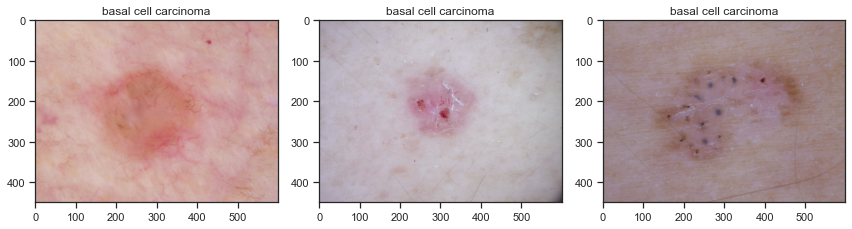

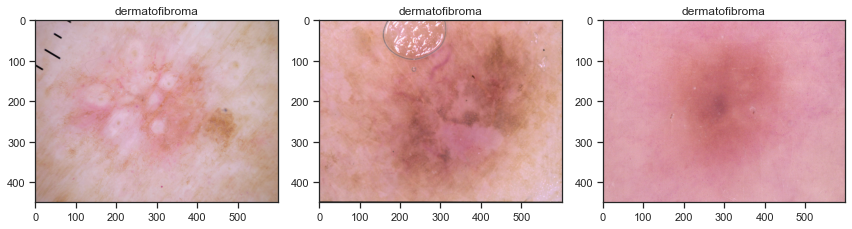

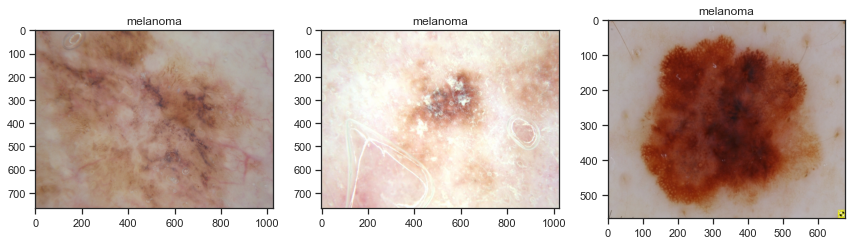

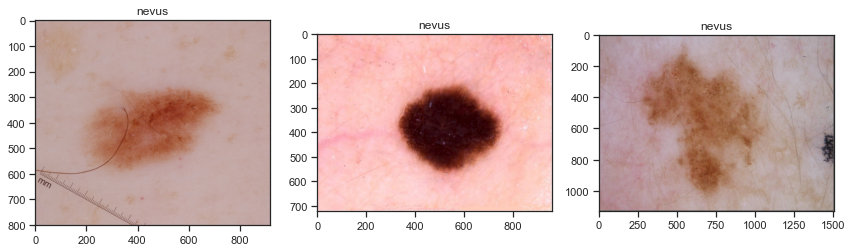

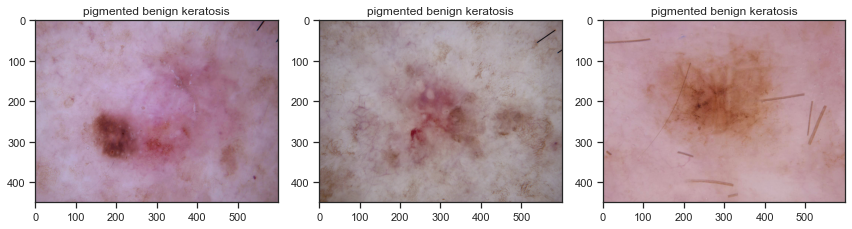

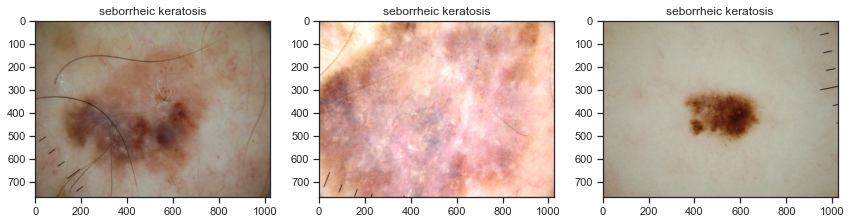

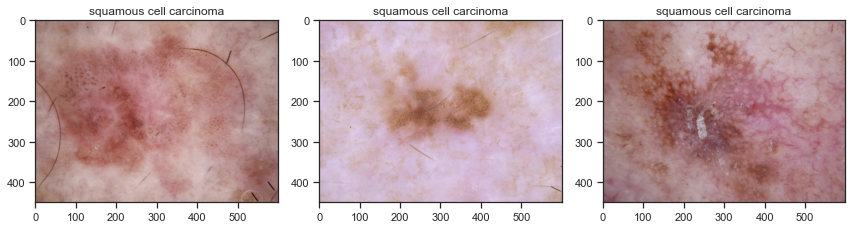

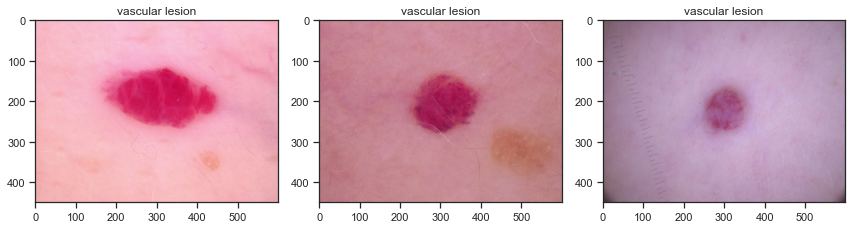

In [8]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df['Labels'].unique())
# loop through labels
for label in labels:
    plot_images_per_label(df, label, 3, (12,9))

In [9]:
# stratified train and val (20%) datasets
X_train, X_val = train_test_split(df, test_size=0.2, stratify=df['Labels'], random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (1791, 2)
Val Data:  (448, 2)


In [10]:
# number of samples/images per iteration
BATCH_SIZE = 32
# input image size
IMG_SIZE = (224, 224)
# count of epchos
EPOCHS = 15

# image preprocessing
img_data_gen = ImageDataGenerator(shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

X_train = img_data_gen.flow_from_dataframe(dataframe=X_train,
                                           x_col='FilePaths',
                                           y_col='Labels',
                                           target_size=IMG_SIZE,
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           batch_size=BATCH_SIZE,
                                           seed=1)

X_val = img_data_gen.flow_from_dataframe(dataframe=X_val,
                                         x_col='FilePaths',
                                         y_col='Labels',
                                         target_size=IMG_SIZE,
                                         color_mode='rgb',
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         seed=1)

Found 1791 validated image filenames belonging to 9 classes.
Found 448 validated image filenames belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input dat

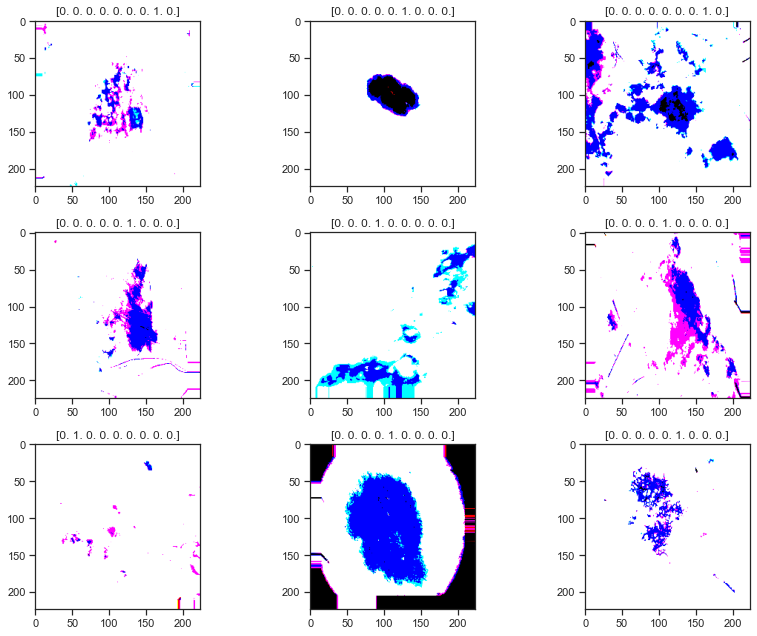

In [11]:
fit, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,9))

for i, a in enumerate(ax.flat):
    img, label = X_train.next()
    a.imshow(img[0],)
    a.set_title(label[0])

plt.tight_layout()
plt.show()

In [12]:
model = Sequential()
# scale image size to 0..1
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))

# 1. Conv2D layer
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# 2. Conv2D layer
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# 3. Conv2D layer
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# scale to 1 dimensional input for NN
model.add(Flatten())

# hidden fully connected layer
model.add(Dense(256))
model.add(Activation('relu'))

# inhibit overfitting
model.add(Dropout(0.2))

# output fully connected layer
model.add(Dense(9))
model.add(Activation('softmax'))

# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

2022-03-05 16:52:58.721725: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# stop training when accuracy has stopped improving 
# cb = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
# hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS, callbacks=cb)
# train model 
hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS)

Epoch 1/15
56/56 [==============================] - 280s 5s/step - loss: 17.0277 - accuracy: 0.2853 - val_loss: 31.3508 - val_accuracy: 0.1674
Epoch 2/15
56/56 [==============================] - 259s 5s/step - loss: 3.3215 - accuracy: 0.2792 - val_loss: 56.8539 - val_accuracy: 0.1674
Epoch 3/15
56/56 [==============================] - 281s 5s/step - loss: 2.0835 - accuracy: 0.3093 - val_loss: 45.5483 - val_accuracy: 0.2210
Epoch 4/15
56/56 [==============================] - 258s 5s/step - loss: 1.9807 - accuracy: 0.3227 - val_loss: 23.4745 - val_accuracy: 0.2188
Epoch 5/15
56/56 [==============================] - 222s 4s/step - loss: 1.9058 - accuracy: 0.3439 - val_loss: 15.4690 - val_accuracy: 0.1094
Epoch 6/15
56/56 [==============================] - 213s 4s/step - loss: 1.9007 - accuracy: 0.3289 - val_loss: 10.7141 - val_accuracy: 0.1964
Epoch 7/15
56/56 [==============================] - 203s 4s/step - loss: 1.8134 - accuracy: 0.3713 - val_loss: 10.8511 - val_accuracy: 0.2969
Epoch

In [14]:
model.save_weights('model1',save_format='tf')

In [15]:
# load model 
# model.load_weights('model1')

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, None, None, None)  0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 batch_normalization (BatchN  (None, None, None, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    1

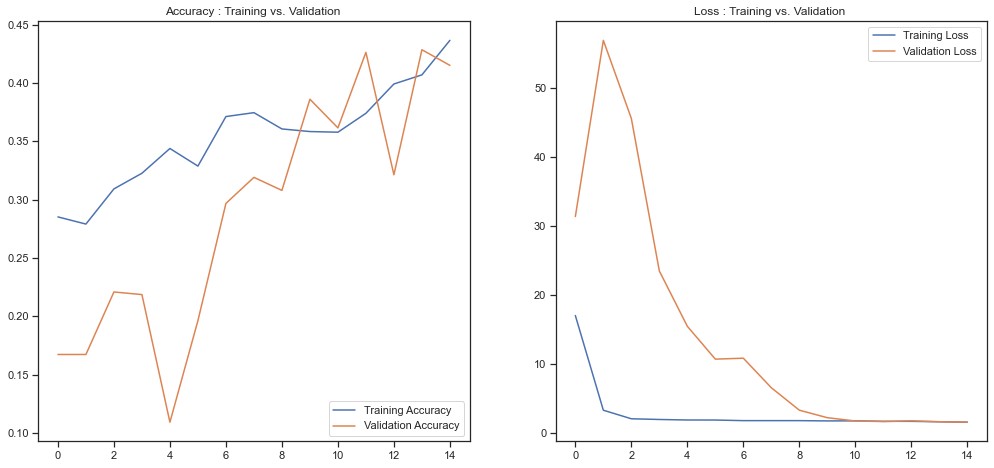

In [16]:
accuracy = hst.history['accuracy']
loss = hst.history['loss']
val_loss = hst.history['val_loss']
val_accuracy = hst.history['val_accuracy']

plt.figure(figsize=(17, 17))
plt.subplot(2, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy : Training vs. Validation ')

plt.subplot(2, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title('Loss : Training vs. Validation ')
plt.legend(loc='upper right')
plt.show()

In [17]:
X_test = load_data(test)

print('Test Data: ', X_test.shape)

# ordered count of rows per unique label
X_test['Labels'].value_counts(ascending=True)

Test Data:  (118, 2)


seborrheic keratosis           3
vascular lesion                3
basal cell carcinoma          16
squamous cell carcinoma       16
pigmented benign keratosis    16
dermatofibroma                16
melanoma                      16
actinic keratosis             16
nevus                         16
Name: Labels, dtype: int64

In [18]:
# image preprocessing of test data
X_test = img_data_gen.flow_from_dataframe(dataframe=X_test,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, # necessary fpr confusion matrix
                                          seed=1)

Found 118 validated image filenames belonging to 9 classes.


In [19]:
# test model
res = model.evaluate(X_test)

# accuracy
print(f'Train Accuracy: {hst.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')
# loss
print(f'Train Loss: {hst.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {hst.history["val_loss"][-1:][0] * 100:.2f}')
print(f'Test Loss: {res[0] * 100:.2f}')

4/4 [==============================] - 13s 3s/step - loss: 3.4659 - accuracy: 0.2797
Train Accuracy: 43.66
Val Accuracy: 41.52
Test Accuracy: 27.97
Train Loss: 158.61
Val Loss: 159.43
Test Loss: 346.59


In [20]:
# predicted labels
Y_pred = model.predict(X_test)
print("Y_pred", Y_pred.shape)
# rounded labels
y_pred = np.argmax(Y_pred, axis=1)
print("y_pred", y_pred.size)

Y_pred (118, 9)
y_pred 118


In [24]:
# true labels
y_true = X_test.classes
#print("y_pred", len(y_pred))
print("y_pred", y_pred);
# label classes
class_labels = list(X_test.class_indices.keys())
print("labels", len(class_labels))

y_pred [5 1 8 5 4 4 5 1 5 4 5 1 5 4 4 4 4 1 1 1 3 1 1 1 1 4 4 4 5 4 1 5 5 8 5 8 4
 1 4 5 4 5 4 3 4 4 5 3 1 4 1 1 8 1 5 1 4 8 1 1 3 1 1 4 1 1 4 1 8 4 4 1 1 3
 5 1 1 5 1 1 5 4 4 1 1 1 1 1 4 5 5 4 1 5 4 4 8 4 1 1 8 4 3 5 1 5 5 3 1 5 4
 1 1 1 1 1 1 1]
labels 9


[Text(0.5, 0, 'actinic\nkeratosis'),
 Text(1.5, 0, 'basal cell\ncarcinoma'),
 Text(2.5, 0, 'dermatofib\nroma'),
 Text(3.5, 0, 'melanoma'),
 Text(4.5, 0, 'nevus'),
 Text(5.5, 0, 'pigmented\nbenign\nkeratosis'),
 Text(6.5, 0, 'seborrheic\nkeratosis'),
 Text(7.5, 0, 'squamous\ncell\ncarcinoma'),
 Text(8.5, 0, 'vascular\nlesion')]

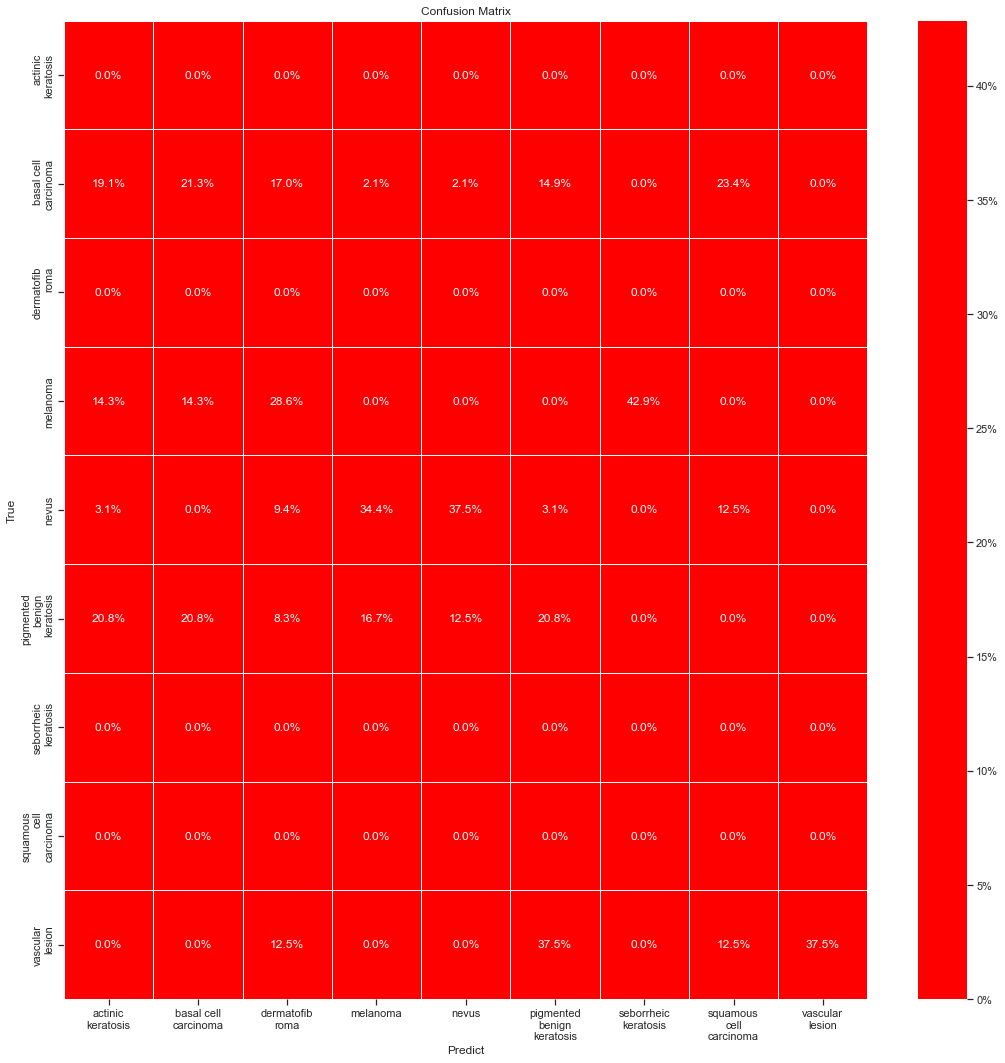

In [36]:
# compare with true labels
cfm = confusion_matrix(y_pred, y_true, normalize='true')

# plot size
fig, ax = plt.subplots(figsize=(18,18))
# print confusion matrix
s = sns.heatmap(cfm,
               annot=True,
               cmap=['#ff0000', '#09AA00'],
               center=0.8,
               fmt='.1%',
               linewidths=.5,
               cbar_kws={'format': FuncFormatter(lambda x, pos: '{:.0%}'.format(x))}, #'label': 'Percentage' 
               linecolor='white',
               ax=ax)
# set labels
s.set(xlabel='Predict', ylabel='True')
s.set(title='Confusion Matrix')
s.set_yticklabels([tw.fill(e, 10) for e in class_labels])
s.set_xticklabels([tw.fill(e, 10) for e in class_labels])

In [46]:
# Predict on Data

def predictCancer(image_path):

    test_data = load_data(image_path)
    test_data = img_data_gen.flow_from_dataframe(dataframe=test_data,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, # necessary fpr confusion matrix
                                          seed=1)
    predictions = model.predict(test_data)

    # Perform statistical normalization on data

    outputValues = [[class_labels],
                     [predictions]]

    return outputValues

test_image = '/Volumes/Extreme SSD/MakeDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Image_Test'
print(predictCancer(test_image))



/var/folders/zq/gw91vncx7hgcs9mspyj7dtk40000gn/T/ipykernel_98538/622473690.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
/var/folders/zq/gw91vncx7hgcs9mspyj7dtk40000gn/T/ipykernel_98538/622473690.py:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  labels = pd.Series(labels, name='Labels').astype(str)


KeyError: 'Labels'